In [35]:
# common imports 
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
np.random.seed(20)

In [36]:
# load data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
print("train:", train.shape)
print("test:", test.shape)

train: (42000, 785)
test: (28000, 784)


In [37]:
y_train = train["label"].values
X_train = train.drop(["label"], axis=1).values

In [38]:
# dimension reduction
from sklearn.decomposition import PCA
def find_component(dat):
    pca = PCA()
    pca.fit(dat)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    dimension = np.argmax(cumsum>=0.95)
    fig = plt.figure(figsize=(12,8))
    plt.plot(cumsum, "b--")
    plt.axhline(y=0.95, linestyle="-", c="red")
    plt.axvline(x=dimension, linestyle="-", c="green")
    plt.annotate("95% Explained Variance, dimension={0}".format(dimension), 
                 xy=(dimension, cumsum[dimension]), 
                 xytext=(dimension, cumsum[dimension]-0.05),
                 arrowprops=dict(facecolor="black"),horizontalalignment="left", verticalalignment="top")
    plt.xlabel("Dimensions")
    plt.ylabel("Explained Variance Ratio")
    plt.show()

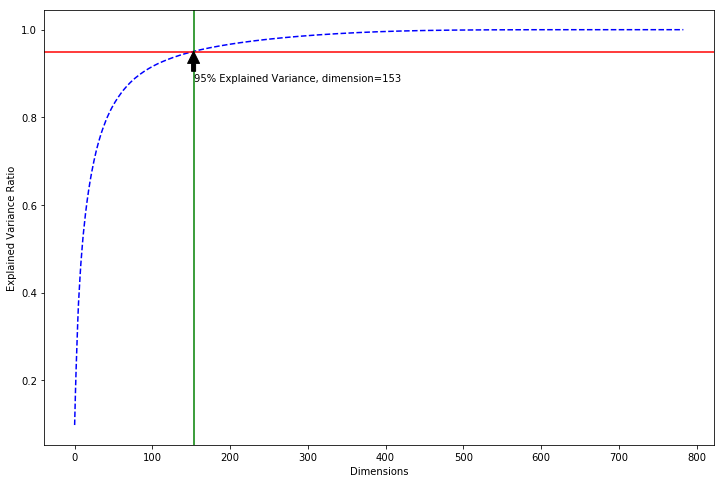

In [39]:
find_component(X_train)

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
pip = Pipeline([("pca", PCA(n_components=0.95)),
               ("scaler", StandardScaler())])
prepared_X_train = pip.fit_transform(X_train.astype(np.float64))
prepared_X_test = pip.transform(test.values.astype(np.float64))

In [46]:
print(prepared_X_train.shape, prepared_X_test.shape)

(42000, 154) (28000, 154)


In [47]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

classifiers = [SVC(decision_function_shape="ovr"),
      RandomForestClassifier(),
      SGDClassifier(),
      KNeighborsClassifier()]

clf_score = {}

for clf in classifiers:
    clf_name = clf.__class__.__name__
    score = cross_val_score(clf, prepared_X_train, y, cv=3, scoring="accuracy")
    if clf_name in clf_score:
        clf_score[clf_name].append(score)
    else:
        clf_score[clf_name] = [score]

In [48]:
for key, value in clf_score.items():
    print(key, ":",value[0].mean())

SVC : 0.966785610904
RandomForestClassifier : 0.866690263297
SGDClassifier : 0.90252405381
KNeighborsClassifier : 0.875857127588


SVC has the highest cross-validation accuracy

In [49]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform
svm_clf = SVC(decision_function_shape="ovr")
param_dist = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_dist, cv=3, scoring="accuracy", verbose=4, n_jobs=-1, n_iter=5)
rnd_search_cv.fit(prepared_X_train, y)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed: 25.9min remaining:  6.5min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 39.4min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params={}, iid=True, n_iter=5, n_jobs=-1,
          param_distributions={'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000019536E04198>, 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000019536E04710>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='accuracy', verbose=4)

In [50]:
rnd_search_cv.best_estimator_

SVC(C=3.9533501415054362, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0045461621820882796,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [51]:
rnd_search_cv.best_score_

0.97007142857142858

In [52]:
clf = rnd_search_cv.best_estimator_
prediction = clf.predict(prepared_X_train)

In [53]:
from sklearn.metrics import accuracy_score
accuracy_score(prediction, y)

0.9997380952380952